#Chest X-Ray Classification | DenseNet | 92%





This project aims to classify pediatric chest X-ray images into two categories: Normal and Pneumonia. The dataset consists of 5,863 images across train, test, and validation sets. Expert physicians from Guangzhou Women and Children’s Medical Center graded the images.
- Dataset link :https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

## 1. Data Loading

- The project starts by loading the dataset from Kaggle using the Kaggle API. The dataset is then unzipped, and necessary libraries are imported.

## 2. Data Augmentation and Balancing

- To address the data imbalance issue, augmentation techniques are applied to increase the number of normal X-ray images.
- Three different datasets are created with unique augmentations and then concatenated. This balanced dataset is used for training.

## 3. Model Creation and Training

- A DenseNet-161 model, pre-trained on ImageNet, is utilized for transfer learning.
- The last fully connected layer is replaced with a new one for binary classification. The model is trained in two stages: first, only the classifier layer is trained, and then all parameters are fine-tuned.
- Training is performed with cross-entropy loss, Adam optimizer, and a learning rate scheduler.

## 4. Test

- The trained model is evaluated on the test set, displaying an imbalance similar to the training data. Performance metrics such as accuracy, precision, recall, and F1 score are calculated.
- A confusion matrix visualizes the model's performance on the test set.

## 5. Model Evaluation and Visualization

Selected images from the test set are displayed with their actual and predicted labels. Additionally, the model's confidence in its predictions is visualized through probability distributions for each class.

## Conclusion

The DenseNet-based classifier achieves a high accuracy of 92% on the test set, demonstrating its effectiveness in distinguishing between normal and pneumonia chest X-ray images.


# 1. Data Loading

Mounts Google Drive to Colab and sets the Kaggle config directory, then downloads and unzips the chest X-ray pneumonia dataset from Kaggle.


In [1]:
# Import the drive module from google.colab to mount Google Drive
from google.colab import drive

# Mount Google Drive to access datasets and other files
drive.mount('/content/drive')

# Import the os module to set environment variables
import os

# Set the Kaggle configuration directory to the specific folder in Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/kaggle'

# Download the dataset from Kaggle using the Kaggle API
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset, overwrite any existing files quietly
!unzip -q -o chest-xray-pneumonia.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


Importing the required libraries

In [2]:
!pip3 install torch torchvision torchaudio

In [3]:
!pip install mlxtend



# About the Dataset

**The dataset includes 5,863 pediatric chest X-ray images categorized into Pneumonia/Normal across train, test, and validation folders. Images were quality controlled and graded by expert physicians from Guangzhou Women and Children’s Medical Center.**


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time
# Pytorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Check if CUDA is available, if yes, use GPU (cuda:0), otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

\let's designate the path as a variable so as not to write a long path

In [5]:
path = 'chest_xray/chest_xray'

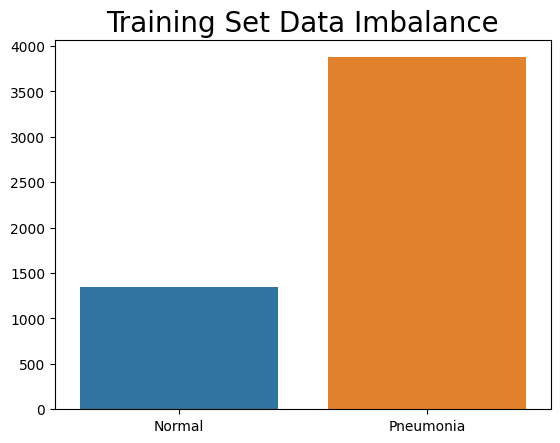

In [6]:
# Create a DataFrame to store the sample sizes of each class in the training set
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename)
                     for filename in os.listdir(path+'/train/NORMAL')])],
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]}
)

# Visualize the sample sizes using a bar plot
sns.barplot(data=train_samplesize).set_title('Training Set Data Imbalance', fontsize=20)
plt.show()

To balance the dataset, we will add 1193 normal X-rays from a third dataset and apply unique augmentations to prevent duplicates. This will increase the number of training examples and address data imbalance.

Here are the augmentations for datasets

In [7]:
from torchvision import transforms as transform

# Define a dictionary to store different transformations for each dataset
transformer = {
    # For dataset1
    'dataset1': transform.Compose([
        transform.Resize(255),                    # Resize images to 255x255 pixels
        transform.CenterCrop(224),                # Crop the center of the image to 224x224 pixels
        transform.RandomHorizontalFlip(),         # Randomly flip the image horizontally
        transform.RandomRotation(10),             # Randomly rotate the image up to 10 degrees
        transform.RandomGrayscale(),             # Randomly convert the image to grayscale
        transform.RandomAffine(translate=(0.05, 0.05), degrees=0),  # Apply random affine transformation
        transform.ToTensor()                      # Convert the image to a PyTorch tensor
    ]),

    # For dataset2
    'dataset2': transform.Compose([
        transform.Resize(255),                    # Resize images to 255x255 pixels
        transform.CenterCrop(224),                # Crop the center of the image to 224x224 pixels
        transform.RandomHorizontalFlip(p=1),      # Always flip the image horizontally
        transform.RandomGrayscale(),             # Randomly convert the image to grayscale
        transform.RandomAffine(translate=(0.1, 0.05), degrees=10),  # Apply random affine transformation
        transform.ToTensor()                      # Convert the image to a PyTorch tensor
    ]),

    # For dataset3
    'dataset3': transform.Compose([
        transform.Resize(255),                    # Resize images to 255x255 pixels
        transform.CenterCrop(224),                # Crop the center of the image to 224x224 pixels
        transform.RandomHorizontalFlip(p=0.5),    # Randomly flip the image horizontally with 50% probability
        transform.RandomRotation(15),             # Randomly rotate the image up to 15 degrees
        transform.RandomGrayscale(p=1),          # Always convert the image to grayscale
        transform.RandomAffine(translate=(0.08, 0.1), degrees=15),  # Apply random affine transformation
        transform.ToTensor()                      # Convert the image to a PyTorch tensor
    ])
}


Let's create datasets and concatenate them

In [8]:
# Create datasets with different transformations
dataset1 = ImageFolder(path+'/train', transform=transformer['dataset1'])
dataset2 = ImageFolder(path+'/train', transform=transformer['dataset2'])
dataset3 = ImageFolder(path+'/train', transform=transformer['dataset3'])

# Splitting and combining datasets
# Split dataset2 into normal (norm1) and pneumonia (pneum1) images according to test_size ratio
norm1, _ = train_test_split(dataset2, test_size=3875/(1341+3875), shuffle=False)
# Split dataset3 into normal (norm2) and pneumonia (pneum2) images according to test_size ratio
norm2, _ = train_test_split(dataset3, test_size=4023/(1341+3875), shuffle=False)

# Concatenate datasets into one combined dataset
dataset = ConcatDataset([dataset1, norm1, norm2])

# Get the length of the combined dataset
len(dataset)

7750

We know in advance what classes there are, but sometimes it is useful to be able to view classes from the dataset

In [9]:
print(dataset1.classes)

['NORMAL', 'PNEUMONIA']


Let's display X-rays with diagnoses. To be honest, I don't see any difference between a pneumonia X-ray and a normal X-ray)

In [10]:
# Function for plotting samples
def plot_samples(samples):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 8))

    # Loop through each sample
    for i in range(len(samples)):
        # Read the image using skimage and convert it to RGB format using OpenCV
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)

        # Plot the image on the corresponding axis
        ax[i // 5][i % 5].imshow(image)

        # Set the title of the subplot based on the sample type
        if i < 5:
            ax[i // 5][i % 5].set_title("Normal", fontsize=20)
        else:
            ax[i // 5][i % 5].set_title("Pneumonia", fontsize=20)

        # Turn off axis labels for better visualization
        ax[i // 5][i % 5].axis('off')

### Observations:
The function plot_samples displays 10 images in a 2x5 grid, distinguishing between normal and pneumonia samples. It utilizes OpenCV for image processing and disables axis labels for clearer visualization.


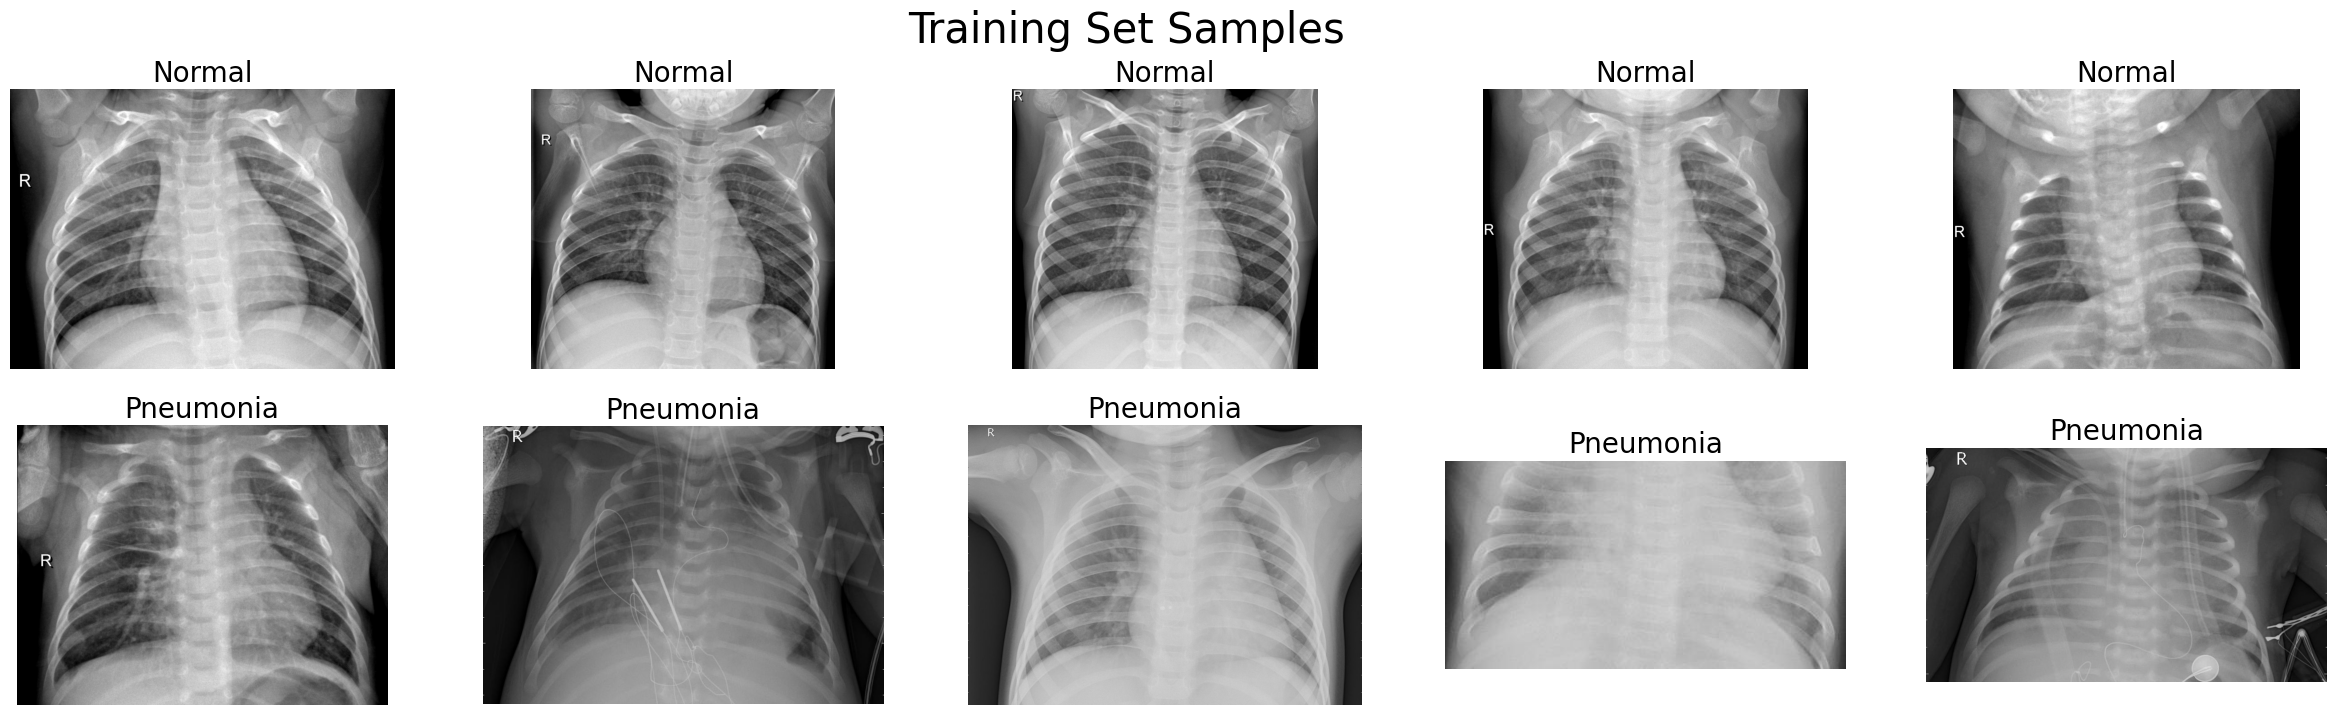

In [11]:
# Randomly select 5 samples from the normal class and 5 samples from the pneumonia class

rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename)
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename)
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

# 2. Train-Validation Data Preparation

To ensure sufficient data for evaluation, we'll split the 'train' folder into training and validation sets. Despite a separate validation folder, it's inadequate for robust evaluation. We'll allocate a 70-30 ratio in favor of training due to the limited validation data.

In [12]:
# set random seed so we get the same sampling every time for reproducibility
random_seed = 2020
torch.manual_seed(random_seed);

In [13]:
# Split the combined dataset into training and validation sets with a ratio of 70:30
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)

# Display the lengths of the training and validation sets
len(train_ds), len(val_ds)

(5425, 2325)

Let's wrap the data into dataloaders. We will also create a dictionary with dataloggers in order to have quick access to them and a dictionary with their sizes, this will be useful to us for evaluating the model

In [14]:
# Set the batch size for training and validation data loaders
batch_size = 50

# Create a DataLoader for the training dataset with shuffling enabled
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Create a DataLoader for the validation dataset
# Use a larger batch size for validation to utilize memory more efficiently
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

# Combine the data loaders into a dictionary
loaders = {'train': train_dl, 'val': val_dl}

# Store the sizes of the training and validation datasets
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's see what the data with augmentation looks like.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


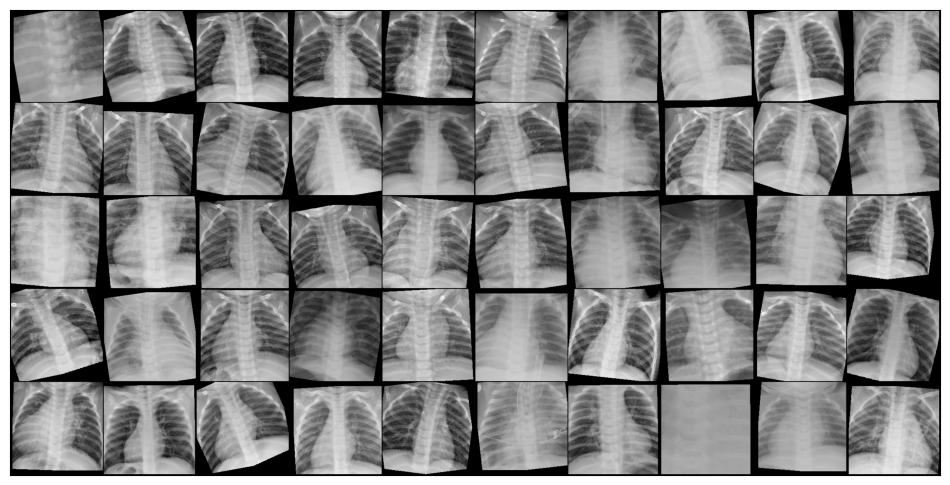

In [15]:
# Function to visualize a batch of images from a data loader
def show_batch(dl):
    # Iterate over batches of data
    for images, labels in dl:
        # Create a new figure
        fig, ax = plt.subplots(figsize=(12, 12))
        # Remove axis ticks
        ax.set_xticks([]); ax.set_yticks([])
        # Display the batch of images as a grid
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        # Display only the first batch
        break

# Display a batch of images from the training data loader
show_batch(train_dl)

# 3. Creating Model

In the third part, we will create the model. We will take a ready-made densenet network and work with it

Since we will have to calculate the accuracy several times, we will write in advance the function for calculating the accuracy

In [16]:
# Function to calculate the accuracy of model predictions
def accuracy(outputs, labels):
    # Determine the predicted labels by selecting the indices with the highest probability
    _, preds = torch.max(outputs, dim=1)
    # Calculate the accuracy by comparing predicted labels with ground truth labels
    acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    return acc, preds


I utilize DenseNet, capitalizing on its pre-trained models for tasks with limited data. This strategy maximizes feature extraction efficiency, leveraging DenseNet's strong gradient flow, parameter effectiveness, and hierarchical feature learning to enhance model performance

![image.png](https://pytorch.org/assets/images/densenet1.png)

Let's create a pre-trained network

In [17]:
model = torchvision.models.densenet161(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Observations:**
In transfer learning with DenseNet, freeze upper layers to retain learned low-level features. Retrain lower layers to adapt to task-specific data. Typically, freeze most layers, except the final fully connected layer. Modify the last layer for the target task, adjusting for class differences. Adaptation depends on dataset disparity and task complexity.

In [18]:
# Freeze all parameters of the model to prevent gradient updates
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the last fully connected layer (classifier)
in_features = model.classifier.in_features

# Replace the last fully connected layer (classifier) with a new one for the target task
model.classifier = nn.Linear(in_features, 2)


In [19]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Training function

In [20]:
# Function to train the model
def train(model, criterion, optimizer, scheduler, epochs):
    since = time.time()  # Record the start time for training
    best_model = copy.deepcopy(model.state_dict())  # Initialize the best model state
    best_acc = 0.0  # Initialize the best validation accuracy

    # Iterate over each epoch
    for epoch in range(epochs):
        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0  # Initialize running loss
            running_corrects = 0.0  # Initialize running correct predictions

            # Iterate over batches of data in the current phase
            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
                optimizer.zero_grad()  # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # Forward pass
                    _, preds = torch.max(outputs, 1)  # Get predicted labels
                    loss = criterion(outputs, labels)  # Calculate loss

                    if phase == 'train':
                        loss.backward()  # Backward pass and optimize only if in training phase
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)  # Update running loss
                running_corrects += torch.sum(preds == labels.data)  # Update running correct predictions

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Record loss and accuracy for the current phase
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            # Print epoch details
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch + 1, epochs))
            print('{} - loss: {:.4f}, accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Print validation time and update best model
            if phase == 'val':
                print('Time: {}m {}s'.format((time.time() - since) // 60, (time.time() - since) % 60))
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model.state_dict())

        scheduler.step()  # Step the scheduler to update learning rate

    # Print total training time and best accuracy
    time_elapsed = time.time() - since
    print('Training Time: {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best accuracy: {:.4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model)
    return model


I would like to draw your attention to the fact that in the optimizer we specify only the classifier

In [21]:
# Define the loss function (criterion) as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Define the optimizer with parameters to optimize and learning rate
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Define the scheduler to adjust learning rate based on epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)


###**Observation:**
The code sets up the training configuration including the loss function (CrossEntropyLoss), optimizer (Adam), and scheduler (StepLR) for learning rate adjustment. These components are crucial for efficient model training and optimization.








In [22]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss: 0.2944, accuracy: 0.9018
val - loss: 0.1649, accuracy: 0.9501
Time: 0.0m 57.374234199523926s
Epoch: 2/10
train - loss: 0.1646, accuracy: 0.9451
val - loss: 0.1278, accuracy: 0.9591
Time: 1.0m 56.91214680671692s
Epoch: 3/10
train - loss: 0.1357, accuracy: 0.9561
val - loss: 0.1135, accuracy: 0.9591
Time: 2.0m 56.9009325504303s
Epoch: 4/10
train - loss: 0.1199, accuracy: 0.9600
val - loss: 0.1055, accuracy: 0.9609
Time: 3.0m 56.576354026794434s
Epoch: 5/10
train - loss: 0.1099, accuracy: 0.9642
val - loss: 0.1051, accuracy: 0.9613
Time: 4.0m 55.905869007110596s
Epoch: 6/10
train - loss: 0.1041, accuracy: 0.9661
val - loss: 0.1064, accuracy: 0.9609
Time: 5.0m 55.05856370925903s
Epoch: 7/10
train - loss: 0.1036, accuracy: 0.9657
val - loss: 0.1081, accuracy: 0.9604
Time: 6.0m 54.23294925689697s
Epoch: 8/10
train - loss: 0.1027, accuracy: 0.9646
val - loss: 0.1055, accuracy: 0.9604
Time: 7.0m 52.74287247657776s
Epoch: 9/10
train - loss: 0.1001, accuracy: 0.9659
val

### **Observations:**
Fine-tuning the entire network post-training of the last layer is a common practice aimed at leveraging pre-trained features for improved performance. However, this approach may not always yield desired results, especially with limited datasets where overfitting is a concern. Therefore, it's advisable to explore two alternatives: either fine-tuning the entire network or selectively fine-tuning specific layers. The former allows for the adaptation of all layers to the new task, potentially enhancing performance, while the latter mitigates overfitting risks by focusing on certain layers. Additionally, adjusting the learning rate, typically by reducing it by a factor of 10, is crucial during fine-tuning to maintain stability in training and preserve the learned features.

In [23]:
# Allow gradient computation for all model parameters
for param in model.parameters():
    param.requires_grad = True

# Define the optimizer with all model parameters and a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.to(device)

grad_clip = None  # Gradient clipping threshold (not used in this configuration)
weight_decay = 1e-4  # Weight decay regularization strength

epochs = 10  # Define the number of training epochs

# Train the model using the train function with specified criterion, optimizer, scheduler, and epochs
model = train(model, criterion, optimizer, scheduler, epochs)


Epoch: 1/10
train - loss: 0.0851, accuracy: 0.9676
val - loss: 0.0527, accuracy: 0.9798
Time: 2.0m 17.412603855133057s
Epoch: 2/10
train - loss: 0.0236, accuracy: 0.9917
val - loss: 0.0545, accuracy: 0.9798
Time: 4.0m 33.90349364280701s
Epoch: 3/10
train - loss: 0.0133, accuracy: 0.9956
val - loss: 0.0765, accuracy: 0.9789
Time: 6.0m 49.973294496536255s
Epoch: 4/10
train - loss: 0.0051, accuracy: 0.9974
val - loss: 0.0600, accuracy: 0.9828
Time: 9.0m 6.008938789367676s
Epoch: 5/10
train - loss: 0.0051, accuracy: 0.9985
val - loss: 0.0546, accuracy: 0.9845
Time: 11.0m 21.995858192443848s
Epoch: 6/10
train - loss: 0.0093, accuracy: 0.9959
val - loss: 0.0959, accuracy: 0.9781
Time: 13.0m 38.213841676712036s
Epoch: 7/10
train - loss: 0.0212, accuracy: 0.9932
val - loss: 0.0836, accuracy: 0.9725
Time: 15.0m 54.259746074676514s
Epoch: 8/10
train - loss: 0.0196, accuracy: 0.9941
val - loss: 0.1152, accuracy: 0.9686
Time: 18.0m 10.474252939224243s
Epoch: 9/10
train - loss: 0.0078, accuracy: 0.

# 4. Test



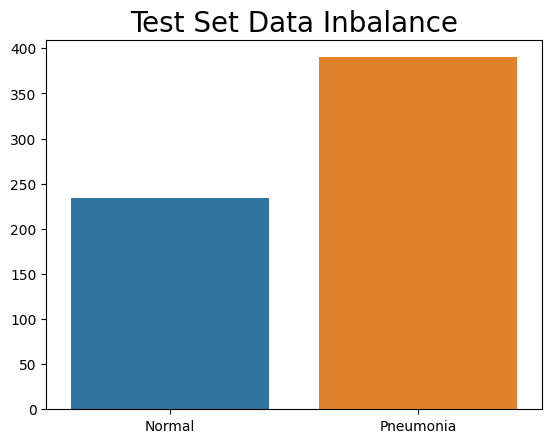

In [24]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/test/NORMAL', filename)
                     for filename in os.listdir(path+'/test/NORMAL')])],
     'Pneumonia': [len([os.path.join(path+'/test/PNEUMONIA', filename)
                        for filename in os.listdir(path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

The following three functions are needed to calculate metrics

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [26]:
# Define a function for validation step
def validation_step(batch):
    images, labels = batch  # Extract images and labels from the batch
    images, labels = images.to(device), labels.to(device)  # Move images and labels to the specified device
    out = model(images)  # Forward pass to get model predictions
    loss = F.cross_entropy(out, labels)  # Calculate cross-entropy loss
    acc, preds = accuracy(out, labels)  # Calculate accuracy and predicted labels using the accuracy function

    # Return dictionary containing validation loss, accuracy, predicted labels, and ground truth labels
    return {'val_loss': loss.detach(), 'val_acc': acc.detach(),
            'preds': preds.detach(), 'labels': labels.detach()}


In [27]:
# Define a function for testing predictions
def test_prediction(outputs):
    # Extract validation losses from each batch and calculate the mean
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()

    # Extract validation accuracies from each batch and calculate the mean
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()

    # Combine predicted labels from all batches
    batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]

    # Combine ground truth labels from all batches
    batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

    # Return dictionary containing test loss, test accuracy, combined predicted labels, and combined ground truth labels
    return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
            'test_preds': batch_preds, 'test_labels': batch_labels}


In [28]:
@torch.no_grad()  # Decorator to disable gradient tracking during testing
def test_predict(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    # Perform testing for each batch in the test loader and get validation outputs
    outputs = [validation_step(batch) for batch in test_loader]
    # Compute test predictions using the test_prediction function
    results = test_prediction(outputs)
    # Print test loss and accuracy
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))

    # Return predicted labels and ground truth labels for evaluation
    return results['test_preds'], results['test_labels']


Let's create a dataset with training x-rays

In [29]:
# Define the test dataset using ImageFolder
testset = ImageFolder(path+'/test',
                      transform=transform.Compose([  # Define transformation pipeline
                          transform.Resize(255),  # Resize images to 255x255
                          transform.CenterCrop(224),  # Center crop images to 224x224
                          transform.ToTensor(),  # Convert images to PyTorch tensors
                      ]))


Evaluate test set

In [30]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.9360, test_acc: 0.8763


# 6. Calculation of some more metrics and visualization of predictions

<Figure size 640x480 with 0 Axes>

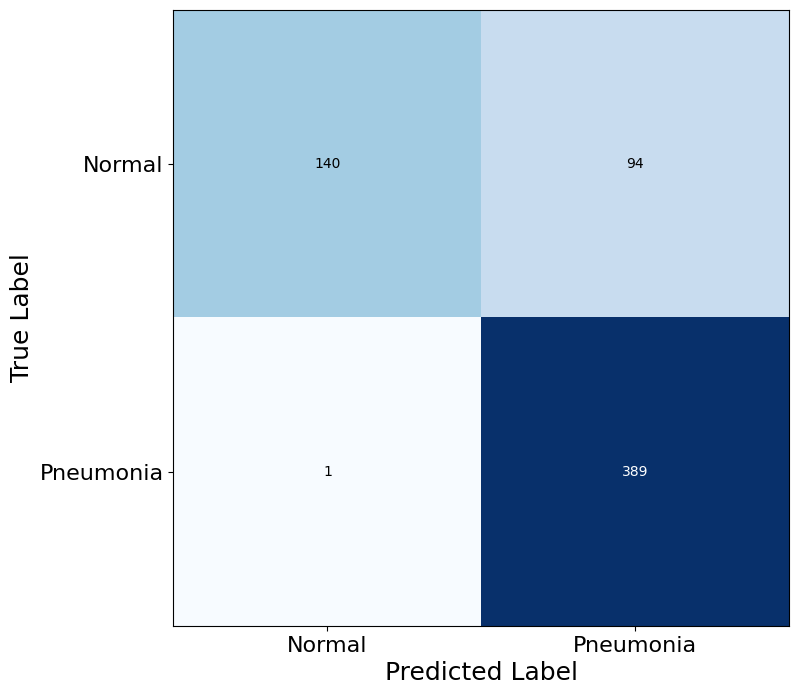

In [31]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [32]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.85
Recall of the model is 1.00
Precision of the model is 0.81
F1 Score of the model is 0.89


Look at X-rays and predictions

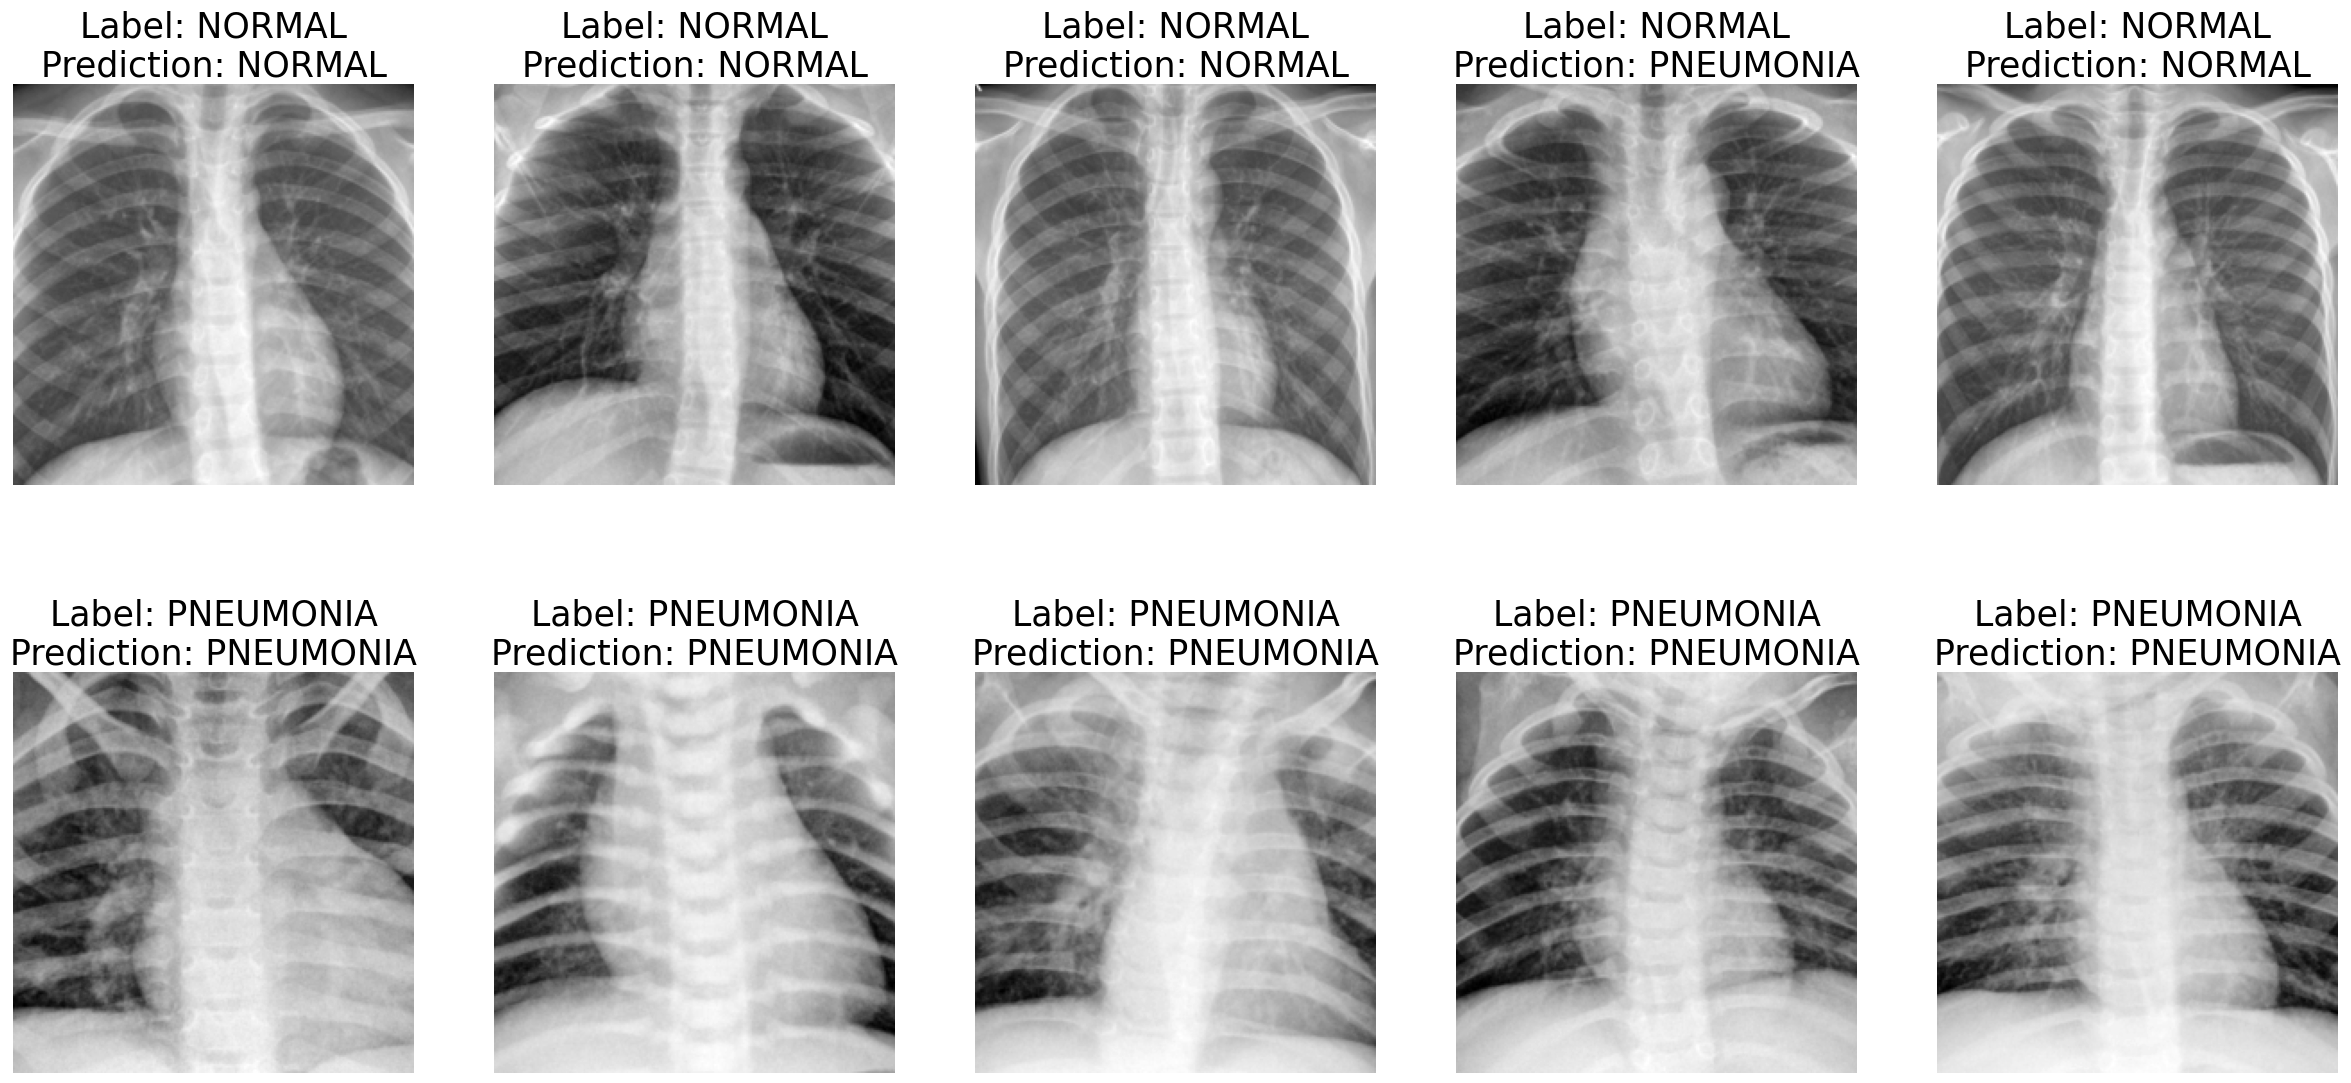

In [33]:
# Select indices for 5 normal and 5 pneumonia images
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1),
                              np.arange(start=500, stop=505, step=1)))

# Create subplots for displaying selected images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

# Iterate over selected indices
for c, i in enumerate(idxs):
    # Get image tensor and label from the test set
    img_tensor, label = testset[i]
    # Display image and set title with actual label and predicted label
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(testset.classes[label],
                                    testset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')  # Remove axis labels


We can also see how strongly the neural network is confident in certain decisions.

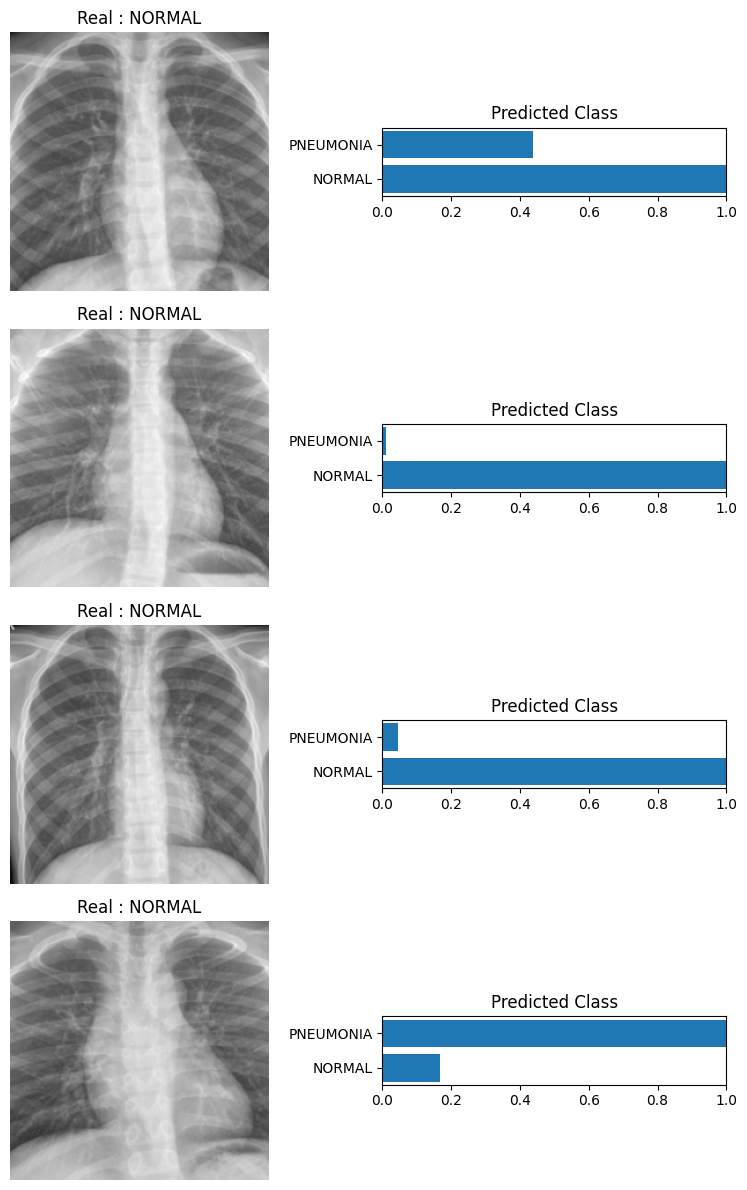

In [34]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

# Iterate over each row
for row in range(4):
    img, label = testset[row]  # Get image and label from the test set
    pred = torch.exp(model(img.to(device).unsqueeze(0)))  # Get model predictions
    class_name = ['NORMAL', 'PNEUMONIA']  # Define class names
    classes = np.array(class_name)  # Convert class names to numpy array
    pred = pred.cpu().data.numpy().squeeze()  # Move predictions to CPU and convert to numpy array

    # Display the original image and actual label
    ax[row][0].imshow(img.permute(1, 2, 0))  # Permute dimensions for correct display
    ax[row][0].set_title('Real : {}'.format(class_name[label]))  # Set title with actual label
    ax[row][0].axis('off')  # Remove axis labels

    # Display the predicted class probabilities as a horizontal bar plot
    ax[row][1].barh(classes, pred)  # Plot horizontal bar chart
    ax[row][1].set_aspect(0.1)  # Set aspect ratio for better visualization
    ax[row][1].set_yticks(classes)  # Set y-axis ticks
    ax[row][1].set_yticklabels(classes)  # Set y-axis tick labels
    ax[row][1].set_title('Predicted Class')  # Set title for predicted class plot
    ax[row][1].set_xlim(0, 1.)  # Set x-axis limits to ensure probabilities are between 0 and 1
    plt.tight_layout()  # Adjust subplot layout

In [35]:
torch.save(model.state_dict(), 'my_model_pneumonia.pt')